In [1]:
# Import necessary plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulation Question 1:
We plotted each set of 200 consecutive data points using the same color!

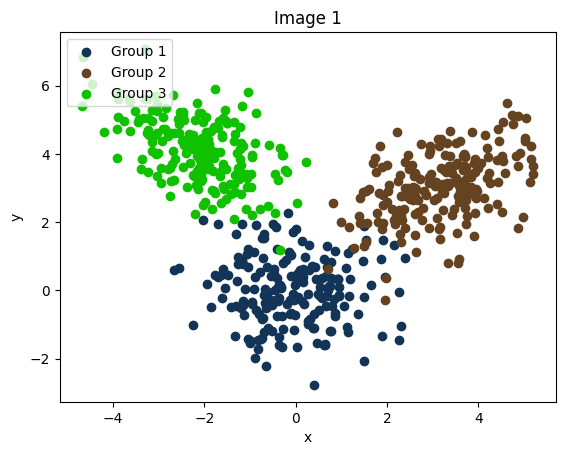

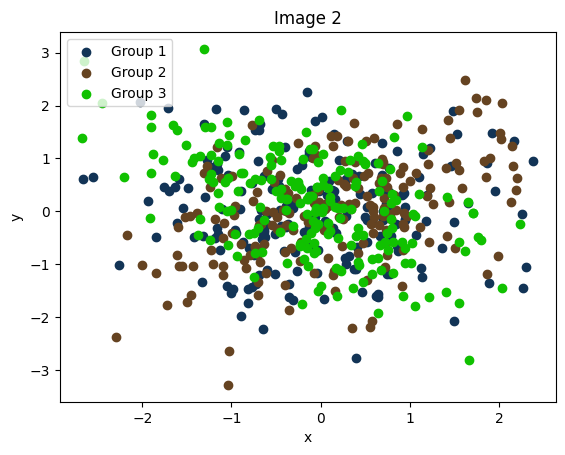

In [2]:
def plot_200(df, name):
    # Create a new figure for the plot
    f = plt.figure()

    # Plot the first 200 data points (index 0 to 199) from the DataFrame
    # The x-coordinates are taken from column '0', and y-coordinates from column '1'
    plt.scatter(df['0'][0:199], df['1'][0:199], color='#123456', label='Group 1')

    # Plot the next 200 data points (index 200 to 399) from the DataFrame
    plt.scatter(df['0'][200:399], df['1'][200:399], color='#654321', label='Group 2')

    # Plot the following 200 data points (index 400 to 599) from the DataFrame
    plt.scatter(df['0'][400:599], df['1'][400:599], color='#10c100', label='Group 3')

    # Add a legend to the upper left of the plot
    plt.legend(loc="upper left")

    # Set the title of the plot
    plt.title(name)

    # Label the x-axis
    plt.xlabel("x")

    # Label the y-axis
    plt.ylabel("y")

    # Display the figure
    f.show()

# Load data from CSV files into pandas DataFrames
df1 = pd.read_csv("Image1.csv")  # Load data from "Image1.csv"
df2 = pd.read_csv("Image2.csv")  # Load data from "Image2.csv"

# Call the plot_200 function for each DataFrame to generate plots
plot_200(df1, "Image 1")
plot_200(df2, "Image 2")

The initialization below was done manually exactly the way it was mentioned
in Theory Question 4:

In [3]:
def initializer(x):
    """
    Initialize the parameters of a Gaussian Mixture Model for 3 components.

    Args:
    x: DataFrame containing two columns ('0', '1'), representing 2D data points.

    Returns:
    pis: Array of size (3,) representing the mixture coefficients (priors).
    covas: Array of size (3, 2, 2) representing the covariance matrices for each of the 3 clusters.
    means: Array of size (3, 2) representing the mean vectors for each of the 3 clusters.
    """
    # Extract the relevant columns as a NumPy array for faster computation
    data = np.array(x.loc[:, ('0', '1')])  # Shape: (600, 2)

    # Initialize parameters
    means = np.zeros((3, 2))  # Means for 3 clusters, each with 2 dimensions
    pis = np.ones(3) / 3      # Mixture coefficients are uniform (1/3 for each cluster)

    # Split data into 3 clusters, each containing 200 points
    cluster_size = 200
    for i in range(3):
        cluster_data = data[i * cluster_size:(i + 1) * cluster_size]  # Slice 200 points for each cluster
        means[i] = np.mean(cluster_data, axis=0)  # Compute mean for each cluster

    # Initialize covariance matrices
    covas = np.zeros((3, 2, 2))  # Covariance matrices for each cluster (2x2 for 2D data)

    # Compute covariance matrices for each cluster
    for i in range(3):
        cluster_data = data[i * cluster_size:(i + 1) * cluster_size]  # 200 points per cluster
        centered_data = cluster_data - means[i]  # Center the data by subtracting the mean
        covas[i] = np.dot(centered_data.T, centered_data) / cluster_size  # Compute covariance matrix

    return pis, covas, means

# Load the data
df1 = pd.read_csv("Image1.csv").sample(frac=1)  # Shuffle data
df2 = pd.read_csv("Image2.csv").sample(frac=1)

# Initialize the parameters for each dataset
pis1, covs1, means1 = initializer(df1)
pis2, covs2, means2 = initializer(df2)

# Simulation Question 2:
The E-Step function below was done manually exactly the way it was mentioned in Theory Question 4:(In this question argmax($w[i]$) indicates which distribution, data $i$ had been assigned to, which is reflected in making $R$ matrix.)

In [4]:
def E_step(x, pis, covs, means):
    """
    Perform the E-step of the Expectation-Maximization (EM) algorithm for Gaussian Mixture Models.

    Parameters:
        x (pd.DataFrame): DataFrame containing the data points, expected to have two columns representing the dimensions.
        pis (np.ndarray): Mixing coefficients (prior probabilities) for each Gaussian component.
        covs (np.ndarray): Covariance matrices for each Gaussian component.
        means (np.ndarray): Mean vectors for each Gaussian component.

    Returns:
        w (np.ndarray): The responsibility weights for each data point for each Gaussian component (shape: n x k_components).
        R (np.ndarray): Responsibility matrix indicating the assigned component for each data point (shape: n x k_components).
    """

    # Convert the DataFrame to a numpy array for faster indexing and manipulation
    a1 = np.array(x.loc[:, ('0', '1')])  # Extract the relevant columns as a numpy array

    # Get the number of data points (n) and the dimensionality (d)
    n, d = a1.shape

    # Get the number of components (k_components) from the length of pis
    k_components = len(pis)

    # Precompute the inverses and determinants of the covariance matrices for efficiency
    inv_covs = np.array([np.linalg.inv(cov) for cov in covs])  # Shape: (k_components, d, d)
    det_covs = np.array([np.linalg.det(cov) for cov in covs])  # Shape: (k_components,)

    # Subtract the means from all data points in a vectorized manner
    # This results in an array of shape (n, k_components, d) where each point is compared with each mean
    diff = a1[:, np.newaxis, :] - means  # Shape: (n, k_components, d)

    # Calculate the Mahalanobis distance for all points with respect to each component in a vectorized way
    # This uses Einstein summation to efficiently compute the distances
    mahalanobis = np.einsum('nkd,kde,nke->nk', diff, inv_covs, diff)  # Shape: (n, k_components)

    # Calculate the Gaussian probabilities for each data point under each component
    # The formula is based on the probability density function of the Gaussian distribution
    w = pis * np.exp(-0.5 * mahalanobis) / np.sqrt((2 * np.pi) ** d * det_covs)

    # Normalize the weights across all components for each data point
    w_sum = w.sum(axis=1, keepdims=True)  # Shape: (n, 1)
    w /= w_sum  # Normalize to ensure probabilities sum to 1 for each data point

    # Compute the responsibility matrix R, assigning 1 to the component with the maximum weight for each point
    R = (w == w.max(axis=1, keepdims=True)).astype(int)  # Shape: (n, k_components)

    return w, R  # Return the calculated weights and the responsibility matrix

w1, R1 = E_step(df1, pis1, covs1, means1)
w2, R2 = E_step(df2, pis2, covs2, means2)

print("R1:")
print(R1)
print("R2:")
print(R2)

R1:
[[1 0 0]
 [0 0 1]
 [0 0 1]
 ...
 [0 0 1]
 [0 1 0]
 [0 0 1]]
R2:
[[0 0 1]
 [0 0 1]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


# Simulation Question 3:
The M-Step function below was done manually exactly the way it was mentioned in Theory Question 4:

In [5]:
def M_step(x, pis, covs, means, w):
    """
    Perform the M-step of the Expectation-Maximization (EM) algorithm for Gaussian Mixture Models.

    Parameters:
        x (pd.DataFrame): DataFrame containing the data points, expected to have two columns representing the dimensions.
        pis (np.ndarray): Current mixing coefficients (prior probabilities) for each Gaussian component.
        covs (np.ndarray): Current covariance matrices for each Gaussian component.
        means (np.ndarray): Current mean vectors for each Gaussian component.
        w (np.ndarray): Responsibility weights for each data point for each Gaussian component (shape: n x k_components).

    Returns:
        pis (np.ndarray): Updated mixing coefficients for each Gaussian component.
        covs (np.ndarray): Updated covariance matrices for each Gaussian component.
        means (np.ndarray): Updated mean vectors for each Gaussian component.
    """

    # Convert the DataFrame to a numpy array for easier manipulation
    a1 = np.array(x.loc[:, ('0', '1')])  # Extract relevant columns as a numpy array

    # Calculate the sum of weights for each component (sum2)
    sum2 = np.sum(w, axis=0)  # Shape: (k_components,)

    # Calculate the weighted sum of data points (sum1) for each component
    sum1 = np.dot(w.T, a1)  # Shape: (k_components, d)

    # Update means by dividing the weighted sum by the sum of weights
    means = sum1 / sum2[:, None]  # Shape: (k_components, d)

    # Update mixing coefficients (pis) as the average weight for each component
    pis = sum2 / a1.shape[0]  # Shape: (k_components,) - average responsibility

    # Initialize an array to hold the weighted covariance matrices
    sum3 = np.zeros((3, 2, 2))  # Assuming 3 components and 2D data

    # Calculate the weighted covariance matrices for each component
    for k in range(3):  # Loop over each component
        temp = a1 - means[k]  # Subtract the mean for component k from each data point
        # Calculate the outer product to obtain the covariance contribution
        weighted_cov = temp[:, :, None] * temp[:, None, :]  # Shape: (n, d, d)
        # Calculate the weighted sum of the outer products
        sum3[k] = np.einsum('i,ijk->jk', w[:, k], weighted_cov)  # Shape: (d, d)

    # Update covariance matrices by normalizing with the sum of weights
    covs = sum3 / sum2[:, None, None]  # Shape: (k_components, d, d)

    return pis, covs, means  # Return updated mixing coefficients, covariance matrices, and means

# Call the function with your data
pis1, covs1, means1 = M_step(df1, pis1, covs1, means1, w1)
pis2, covs2, means2 = M_step(df2, pis2, covs2, means2, w2)

# Print results
print("New means for Image1:")
print(means1)
print("New covariances for Image1:")
print(covs1)
print("New pis for Image1:")
print(pis1)
print("New means for Image2:")
print(means2)
print("New covariances for Image2:")
print(covs2)
print("New pis for Image2:")
print(pis2)

New means for Image1:
[[0.3862819  2.36552715]
 [0.48221497 2.37134419]
 [0.0553676  2.39664097]]
New covariances for Image1:
[[[ 5.68430874 -0.34150697]
  [-0.34150697  3.91609429]]

 [[ 5.68732496 -0.20365086]
  [-0.20365086  3.67676805]]

 [[ 5.42019348 -0.90710631]
  [-0.90710631  4.23617478]]]
New pis for Image1:
[0.33316668 0.33308508 0.33374824]
New means for Image2:
[[-0.0035577   0.07902318]
 [-0.00661998  0.05935048]
 [-0.06644425 -0.00483148]]
New covariances for Image2:
[[[ 1.03849514 -0.02015517]
  [-0.02015517  1.05568077]]

 [[ 0.94161097 -0.0477894 ]
  [-0.0477894   0.85457833]]

 [[ 0.91761369  0.02201197]
  [ 0.02201197  0.86966563]]]
New pis for Image2:
[0.33335877 0.33332362 0.33331761]


# Simulation Question 4:
As you can see we indentify model parameter convergences, and stop the algorithm after convergence was reached!

In [6]:
def run_EM(df, pis, covs, means, name, max_iterations=1500, tol=1e-5):
    """
    Run the Expectation-Maximization (EM) algorithm on a given dataset.

    Parameters:
        df (pd.DataFrame): The dataset containing the data points. It is expected to have two columns representing the dimensions.
        pis (np.ndarray): Initial mixing coefficients (prior probabilities) for each Gaussian component.
        covs (np.ndarray): Initial covariance matrices for each Gaussian component.
        means (np.ndarray): Initial mean vectors for each Gaussian component.
        name (str): A name for the model, used for logging convergence information.
        max_iterations (int): Maximum number of iterations to run the EM algorithm (default is 1500).
        tol (float): Convergence tolerance; the algorithm stops if the changes in parameters are below this threshold (default is 1e-5).

    Returns:
        pis (np.ndarray): Updated mixing coefficients for each Gaussian component.
        covs (np.ndarray): Updated covariance matrices for each Gaussian component.
        means (np.ndarray): Updated mean vectors for each Gaussian component.
        R (np.ndarray): Responsibility matrix indicating the assigned component for each data point.
        i (int): The number of iterations the algorithm ran before converging or reaching the maximum iterations.
    """

    # Make initial copies of the parameters for checking convergence
    covs_pre, means_pre, pis_pre = covs.copy(), means.copy(), pis.copy()

    # Iterate for a maximum number of iterations or until convergence
    for i in range(max_iterations):
        # E-step: Calculate the responsibilities (weights) for the data points
        w, R = E_step(df, pis, covs, means)

        # M-step: Update the mixing coefficients, covariance matrices, and means
        pis, covs, means = M_step(df, pis, covs, means, w)

        # Check for convergence: If the changes in parameters are below the tolerance
        if (np.sum(np.abs(covs_pre - covs)) < tol and
            np.sum(np.abs(pis_pre - pis)) < tol and
            np.sum(np.abs(means_pre - means)) < tol):
            # Log the convergence information
            print(f"{name} converged after {i} iterations.")
            break  # Exit the loop if the model has converged

        # Update the previous parameters with the current ones for the next iteration
        covs_pre[:] = covs
        means_pre[:] = means
        pis_pre[:] = pis

    # Return the updated parameters and the number of iterations run
    return pis, covs, means, R, i + 1

# Usage for running EM on two different models
pis1, covs1, means1, R1, iters1 = run_EM(df1, pis1, covs1, means1, "Model 1")
pis2, covs2, means2, R2, iters2 = run_EM(df2, pis2, covs2, means2, "Model 2")

Model 1 converged after 72 iterations.
Model 2 converged after 1248 iterations.


We will now plot the result of the EM Algorithm:

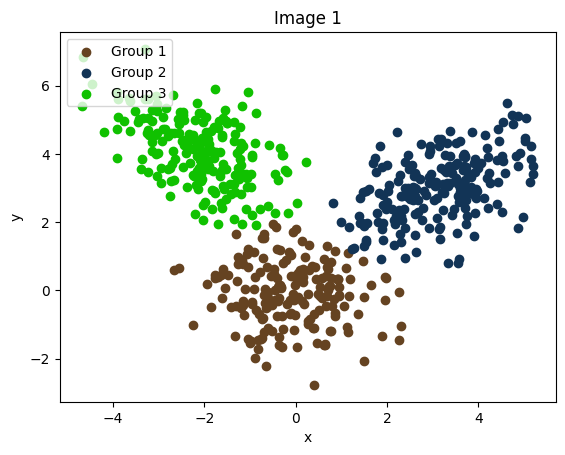

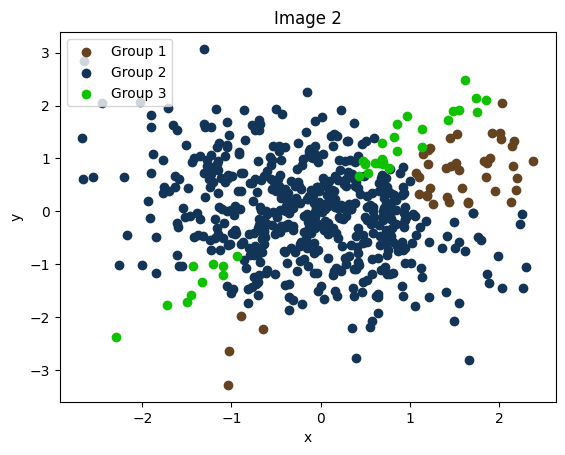

In [7]:
def plot_clusters(df, R, name, colors):
    """
    Plot clusters based on the given data frame and R matrix.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data to plot.
        R (np.ndarray): Responsibility matrix indicating cluster membership.
        title (str): Title for the plot.
        figure_num (int): Figure number for the plot.
        colors (list): List of colors for the clusters.

    Returns:
        None: Displays the plot.
    """
    # Create a new figure
    f = plt.figure()

    # Extract relevant columns from the DataFrame
    mydf = df.loc[:, ("1", "0")]

    # Add responsibility values to the DataFrame
    mydf["c1"] = R[:, 0]
    mydf["c2"] = R[:, 1]
    mydf["c3"] = R[:, 2]

    # Plot points belonging to each cluster with corresponding colors
    plt.scatter(mydf.loc[mydf["c1"] == 1, "0"], mydf.loc[mydf["c1"] == 1, "1"], c=colors[1], label='Group 1')
    plt.scatter(mydf.loc[mydf["c2"] == 1, "0"], mydf.loc[mydf["c2"] == 1, "1"], c=colors[0], label='Group 2')
    plt.scatter(mydf.loc[mydf["c3"] == 1, "0"], mydf.loc[mydf["c3"] == 1, "1"], c=colors[2], label='Group 3')

    # Add legend and titles
    plt.legend(loc="upper left")
    plt.title(name)
    plt.xlabel("x")
    plt.ylabel("y")

    # Display the plot
    plt.show()

# Usage of the plot_clusters function for both models
colors = ['#123456', '#654321', '#10c100']
plot_clusters(df1, R1, "Image 1", colors)
plot_clusters(df2, R2, "Image 2", colors)

# Simulation Question 5:

In [8]:
# Print the means for the first image
print("Means for Image1:")
# The means represent the center of each Gaussian component in the mixture model for Image1.
print(means1)

# Print the covariance matrices for the first image
print("Covariances for Image1:")
# The covariance matrices describe the spread or shape of each Gaussian component for Image1.
print(covs1)

# Print the mixing coefficients (pis) for the first image
print("Pis for Image1:")
# The mixing coefficients indicate the weight or importance of each Gaussian component in the mixture for Image1.
print(pis1)

# Print the means for the second image
print("Means for Image2:")
# The means for Image2, similar to Image1, represent the centers of the Gaussian components in the model.
print(means2)

# Print the covariance matrices for the second image
print("Covariances for Image2:")
# The covariance matrices for Image2 indicate how the data points are distributed around the means of the Gaussian components.
print(covs2)

# Print the mixing coefficients (pis) for the second image
print("Pis for Image2:")
# The mixing coefficients for Image2 show the relative contribution of each Gaussian component in the overall model.
print(pis2)

Means for Image1:
[[-0.12367251 -0.0704259 ]
 [ 3.10318836  2.98038325]
 [-2.08813467  4.06679576]]
Covariances for Image1:
[[[ 0.90044937 -0.07791951]
  [-0.07791951  0.85842185]]

 [[ 1.06529168  0.50241421]
  [ 0.50241421  0.96253729]]

 [[ 0.89077384 -0.48958988]
  [-0.48958988  0.98895757]]]
Pis for Image1:
[0.31870768 0.34092257 0.34036975]
Means for Image2:
[[ 0.75779094 -0.12154576]
 [-0.20040883  0.05887316]
 [-0.08352634  0.1711855 ]]
Covariances for Image2:
[[[ 0.69988188  0.62536763]
  [ 0.62536763  1.01013764]]

 [[ 0.9036222  -0.27987339]
  [-0.27987339  0.9137444 ]]

 [[ 0.71182087  0.73250161]
  [ 0.73250161  0.85072904]]]
Pis for Image2:
[0.16563492 0.69612487 0.13824021]


In image1, the datapoints are concentrated at three different regions clearly. Therefore it is obvious that they have come from 3 different distributions. So, even by shuffling the dataframe at first and then using the described algorithm for initialization of parameters, and even with small numbers of iteration, we would have the parameters converged approximately to their actual value.
In which the means of three MVN distributions, have considerable distances from each other; so that the clustering is approximately correct.

While in image2 the means of the distributions are so close that it becomes very difficult to separate them from each other, and we may reach different results for clustering in different iterations of the whole algorithm and have a lower percentage of accuracy.(concentration of the most points is at the centre of the picture and they are too close together.)

The fact that clustering the second image is more difficult could also be seen by the calculated means of the last iteration of the algorithm, in which for the first image we see a high level of diversity, but for image2 the opposite; although there are some differences in covs and pis matrices of the two, the main difference seems to be due to the means at the end.

On the other hand, the final answer becomes too sensitive to the initialization. And different initializations make different means so that the clustering may differ significantly(Actually for the central points). That shows the lower accuracy percentage of the algorithm in this photo compared to the previous photo.
Of course we tried several initialization algorithms to work better for generalized problem and different datasets. That the one which is used is the best and has less differences in the results compared to the others
